AO3 analysis: tags
==========

This notebook presents the code used to generate the plots in [post 3]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses the top tags on the AO3 by various metrics.

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
from adjustText import adjust_text

from ao3db import ao3db
from utils import format_tag, write_dataframe, rescale_axis

In [2]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [3]:
db = ao3db()

First, let's work out the top tags by uses and by total hits on works with those tags.

In [4]:
# We'll pull all the tag data & associate it with a number of hits.
# Sometimes a work is tagged with two tags that mean the same thing--let's get rid of those duplicates.
data = db.get_data('Hits', 'TagName', 'ID', 'Date', duplicates=False)
avg_hit = np.sum(1.0*data['Hits'])/len(data)
# These are URL-formatted tags. Let's reformat the TagName field to be prettier.
data['TagName'] = data['TagName'].map(format_tag)
tag_counts = data['TagName'].value_counts()

# Print out the top thousand tags to a file, so we can look for fun stuff later
write_dataframe(tag_counts.head(1000), 'top_tags_by_work.dat')

# Now do the same as above, but sum the hits and sort that way, instead of just counting uses
tag_counts_by_hits = data.groupby('TagName').sum().drop(["ID"], axis=1)
tag_counts_by_hits = tag_counts_by_hits.sort_values("Hits", ascending=False)
write_dataframe(tag_counts_by_hits.head(1000), 'top_tags_by_hits.dat')

In [5]:
canonical_tags = db.get_data('TagName', 'TagCategory')
canonical_tags['TagName'] = canonical_tags['TagName'].map(format_tag)
characters = canonical_tags.query("TagCategory == 'character'")
character_tag_counts = tag_counts.loc[tag_counts.index.isin(characters['TagName'])].sort_values(ascending=False)
write_dataframe(character_tag_counts.head(1000), 'top_character_tags.dat')
character_tag_counts_by_hits = tag_counts_by_hits.loc[tag_counts_by_hits.index.isin(characters['TagName'])].sort_values(by='Hits', axis=0, ascending=False)
write_dataframe(character_tag_counts_by_hits.head(1000), 'top_character_tags_by_hits.dat')

relationships = canonical_tags.query("TagCategory == 'relationship'")
relationship_tag_counts = tag_counts.loc[tag_counts.index.isin(relationships['TagName'])].sort_values(ascending=False)
write_dataframe(relationship_tag_counts.head(1000), 'top_relationship_tags.dat')
relationship_tag_counts_by_hits = tag_counts_by_hits.loc[tag_counts_by_hits.index.isin(relationships['TagName'])].sort_values(by='Hits', ascending=False)
write_dataframe(relationship_tag_counts_by_hits.head(1000), 'top_relationship_tags_by_hits.dat')

freeforms = canonical_tags.query("TagCategory == 'free'")
freeform_tag_counts = tag_counts.loc[tag_counts.index.isin(freeforms['TagName'])].sort_values(ascending=False)
freeform_tag_counts_by_hits = tag_counts_by_hits.loc[tag_counts_by_hits.index.isin(freeforms['TagName'])].sort_values(by='Hits', ascending=False)
top_tags = freeform_tag_counts.head(10).index
top_tags_index = set(top_tags) | set(freeform_tag_counts_by_hits.head(10).index)

We can plot those two quantities against each other to see if readers & creators have similar tastes.

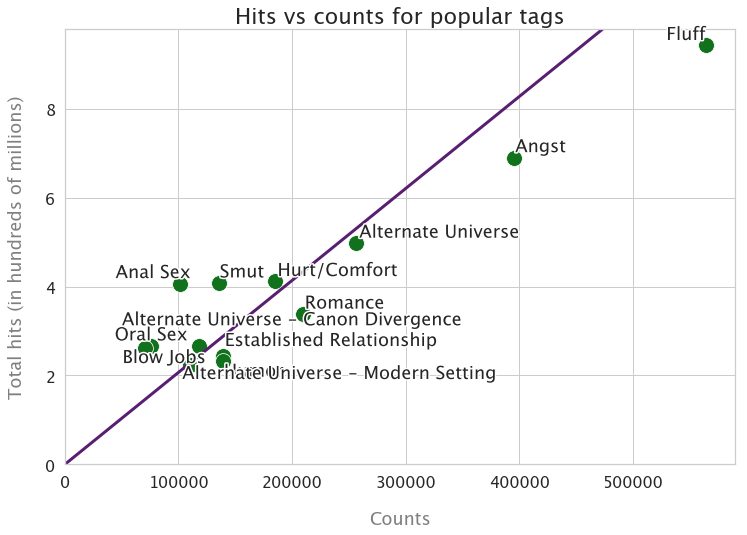

In [6]:
fig, ax = plt.subplots()
tag_comparison = tag_counts_by_hits.join(tag_counts)
tag_comparison = tag_comparison.loc[tag_comparison.index.isin(top_tags_index)].rename(columns={'TagName': 'Counts'})
sns.scatterplot(x='Counts', y='Hits', data=tag_comparison, ax=ax, color=single_color, s=250)
texts = []
for i, (indx, tc) in enumerate(tag_comparison.iterrows()):
    text = ax.text(tc["Counts"], tc["Hits"], format_tag(indx))
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])
    texts.append(text)
adjust_text(texts)
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0, ax.get_xlim()[1]))
maxmin = np.array(ax.get_xlim())
ax.plot(maxmin, maxmin*avg_hit, color=sns.color_palette("dark")[4], lw=3)
ax.set_ylabel("Total hits")
rescale_axis(ax, axis='y', rescale=100000000)
ax.set_title("Hits vs counts for popular tags")
fig.savefig("tag_counts_hits_vs_counts.png")

We can also plot the top tags (by uses) over time:

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


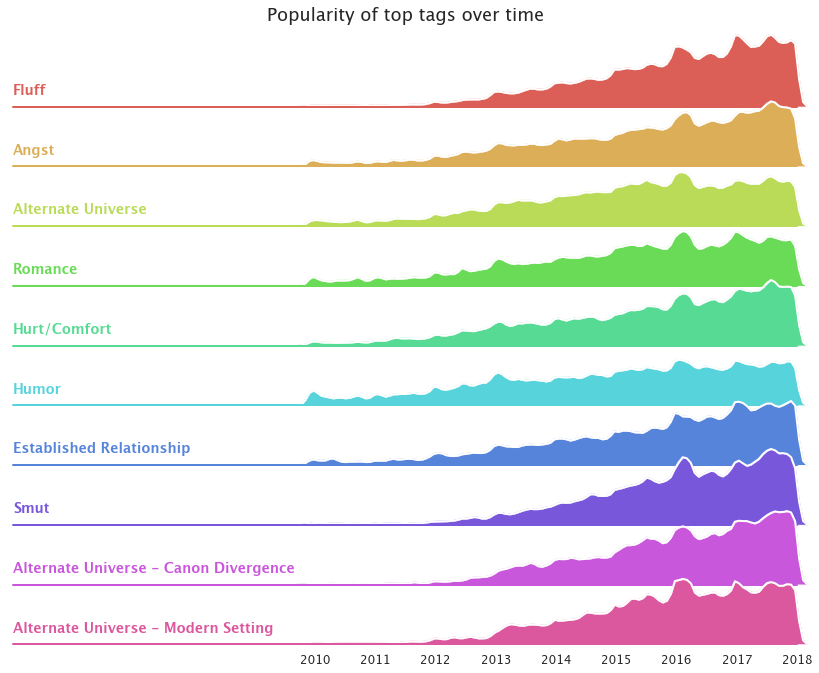

In [7]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Since a work can be tagged with multiple tags that resolve to the same canonical tag,
# get rid of duplicate entries and then drop the "ID" col we don't need.
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

if 'saved_data' in vars():
    data = saved_data
else:
    saved_data = data
data = data[data["TagName"].isin(top_tags)]
data["OrdinalDate"] = [d.toordinal() for d in data['Date']] 
desired_xticks = [datetime.date(yr, 1, 1).toordinal() for yr in range(2010, 2019)]
desired_xlim = (datetime.date(2009, 11, 15).toordinal(), datetime.date(2018, 1, 1).toordinal())
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y') for x in desired_xticks]

data = data.query('OrdinalDate > {}'.format(desired_xlim[0]))
data = data.query('OrdinalDate < {}'.format(desired_xlim[1]))

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# I couldn't get the figsize keyword to pass properly, so this is a hacky workaround
rcParams['figure.figsize'] = (18.0, 30.0)
g = sns.FacetGrid(data, row="TagName", hue="TagName", aspect=12, height=1, palette='hls',
                  row_order=top_tags, hue_order=top_tags)

# Draw the densities in a few steps
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=20)#, bw=.2)
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, color="w", lw=2, bw=20)#, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "TagName")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

desired_long_xlim = [datetime.date(yr, 1, 1).toordinal() for yr in range(2005, 2020)] # enough room for labels!

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
#        g.set(xlim=(desired_xticks[0], dmax))
g.set(xticks=desired_xticks)
g.set(xticklabels=xlabels)
g.set(xlim=(desired_long_xlim[0], max(data['OrdinalDate'])))
g.set(xlabel='')
g.despine(bottom=True, left=True)
g.axes[0][0].set_title("Popularity of top tags over time")
g.savefig("tags_by_date.png")